In [8]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import scipy.special as ss

In [4]:
# Define the true function and generate noisy observations
t = np.linspace(0, 10, 100)
y_true = np.sin(t)
noise = np.random.normal(0, 0.1, t.shape)
y_noisy = y_true + noise

In [5]:
kernel_rbf = RBF(length_scale=1.0)
gp_rbf = GaussianProcessRegressor(kernel=kernel_rbf, alpha=0.1, optimizer='fmin_l_bfgs_b')
gp_rbf.fit(t.reshape(-1, 1), y_noisy)

GaussianProcessRegressor(alpha=0.1, kernel=RBF(length_scale=1))

In [6]:
gp_rbf.kernel_

RBF(length_scale=1.85)

In [7]:
# Define the RBF kernel function
def rbf_kernel(t1, t2, length_scale=1.0):
    return np.exp(-0.5 * (np.subtract.outer(t1, t2) ** 2) / length_scale**2)

In [21]:
def rbf(z, length_scale=1.0):
    return np.exp(-0.5*(z/length_scale)**2)

In [22]:
# using Hermite polynomials
def drbf(n, z, l=1.0):
    herm = ss.hermite(n)
    return ((-1)**n)*((2*l**2)**(-n/2)) * herm(z/np.sqrt(2*l**2)) * rbf(z, l)

In [10]:
sigma_noise = 0.1
computed_length_scale = gp_rbf.kernel_.length_scale

In [11]:
# Training data: Covariance matrix K (with noise term)
K = rbf_kernel(t, t, length_scale=computed_length_scale) + sigma_noise**2 * np.eye(len(t))
K_inv = np.linalg.inv(K)

In [12]:
# Define the covariance between the test points and the training points
k_star = rbf_kernel(t, t, length_scale=computed_length_scale)

In [13]:
# Implement the update formula for the predicted mean y*
y_star = k_star @ K_inv @ y_noisy  

In [14]:
y_pred = gp_rbf.predict(t.reshape(-1, 1))

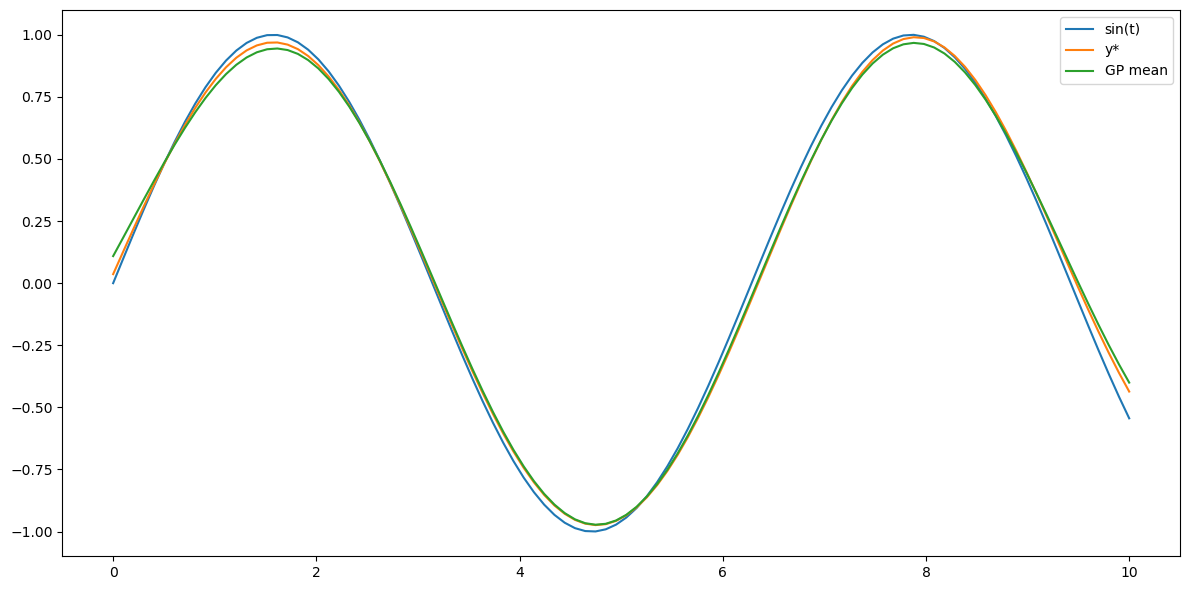

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(t, y_true, label='sin(t)')
plt.plot(t, y_star, label='y*')
plt.plot(t, y_pred, label='GP mean')
plt.legend()
plt.tight_layout()

In [39]:
t1, t2 = np.meshgrid(t, t)
# set up "t1 - t2" as a vector of length apts**2
t1mt2 = (-t1+t2).reshape((100**2))
herm = drbf(1, t1mt2, l=computed_length_scale).reshape((100, 100))

In [40]:
# Compute the gradient of k_star with respect to t
grad_k_star = -(t[:, None] - t[None, :]) / (computed_length_scale**2) * k_star  

In [41]:
dy_dt_star = np.dot(grad_k_star, K_inv @ y_noisy)  

In [42]:
dy_dt_star_herm = np.dot(herm, K_inv @ y_noisy)  

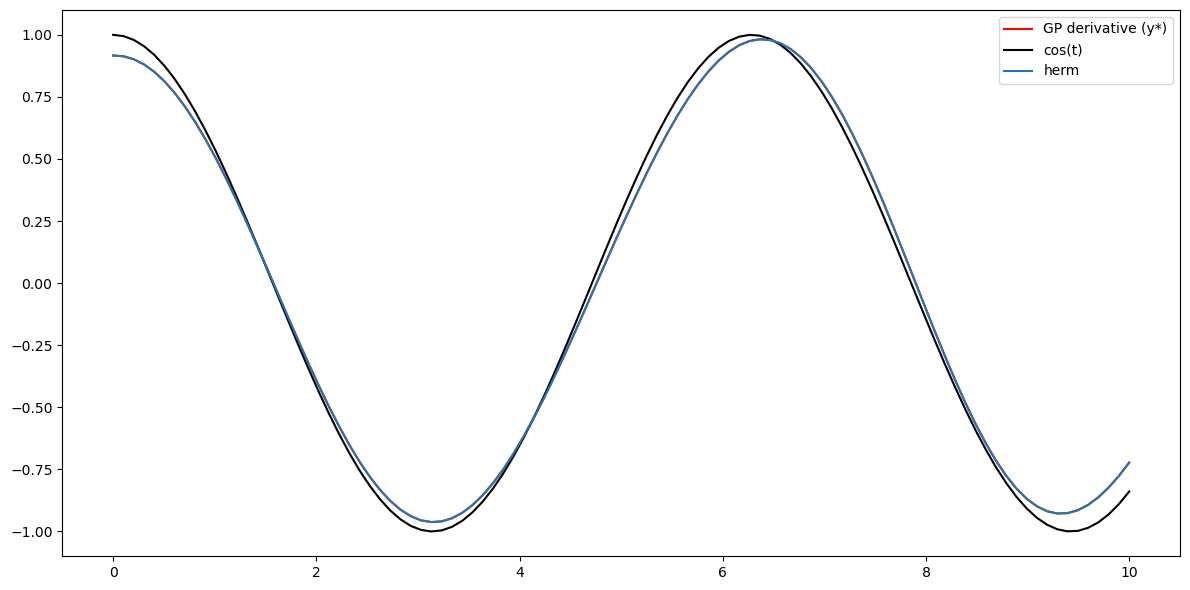

In [44]:
# Plot the results: derivative of the GP mean vs true cosine function
plt.figure(figsize=(12, 6)) 
plt.plot(t, dy_dt_star, label="GP derivative (y*)", color='red')
plt.plot(t, np.cos(t), label='cos(t)', color='black')
plt.plot(t, dy_dt_star_herm, label='herm')
plt.legend()
plt.tight_layout()

In [45]:
# Compute the second derivative of k_star with respect to t
second_deriv_k_star = grad_k_star * -(t[:, None] - t[None, :]) / (computed_length_scale**2) + k_star * (-1 / computed_length_scale ** 2)
d2y_dt2_star = np.dot(second_deriv_k_star, K_inv @ y_noisy) 

In [46]:
herm2 = drbf(2, t1mt2, l=computed_length_scale).reshape((100, 100))
d2y_dt2_star_herm = np.dot(herm2, K_inv @ y_noisy)  

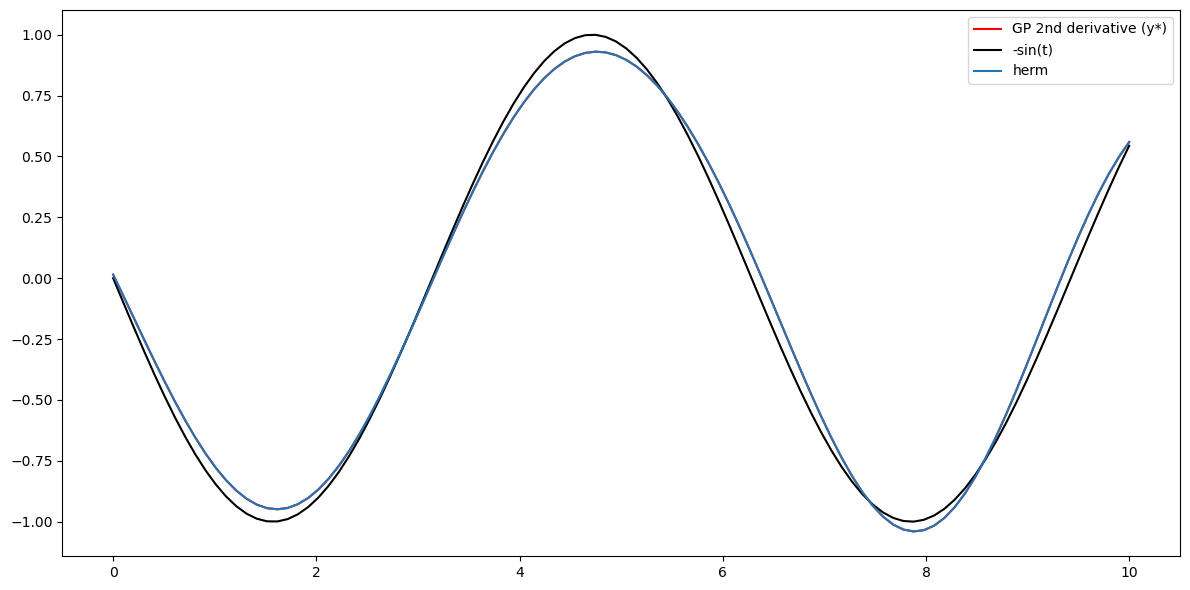

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(t, d2y_dt2_star, label="GP 2nd derivative (y*)", color='red')
plt.plot(t, -np.sin(t), label='-sin(t)', color='black')
plt.plot(t, d2y_dt2_star_herm, label='herm')
plt.legend()
plt.tight_layout()